## IACM ChaCha20 MEASUREMENT

### 1: C Source code: chacha20.c + makefile

<details>
    <summary><b> >>> ChaCha20 SourceCode in C99 <<< (Click to show code) </b></summary>
<br>
    
---
```c
#include <stdint.h>
#include <string.h>
#include <stdio.h>

//#include "chacha20.h"
#include "simpleserial.h"


// check size of input bytes!
#define INPUT_SIZE 64
#define KEY_SIZE 32
#define NONCE_SIZE 12
#define COUNT_SIZE 4



static inline void u32t8le(uint32_t v, uint8_t p[4]) {
    p[0] = v & 0xff;
    p[1] = (v >> 8) & 0xff;
    p[2] = (v >> 16) & 0xff;
    p[3] = (v >> 24) & 0xff;
}

static inline uint32_t u8t32le(uint8_t p[4]) {
    uint32_t value = p[3];

    value = (value << 8) | p[2];
    value = (value << 8) | p[1];
    value = (value << 8) | p[0];

    return value;
}

static inline uint32_t rotl32(uint32_t x, int n) {
    // http://blog.regehr.org/archives/1063
    return x << n | (x >> (-n & 31));
}

// https://tools.ietf.org/html/rfc7539#section-2.1
static void chacha20_quarterround(uint32_t *x, int a, int b, int c, int d) {
    x[a] += x[b]; x[d] = rotl32(x[d] ^ x[a], 16);
    x[c] += x[d]; x[b] = rotl32(x[b] ^ x[c], 12);
    x[a] += x[b]; x[d] = rotl32(x[d] ^ x[a],  8);
    x[c] += x[d]; x[b] = rotl32(x[b] ^ x[c],  7);
}

static void chacha20_serialize(uint32_t in[16], uint8_t output[64]) {
    int i;
    for (i = 0; i < 16; i++) {
        u32t8le(in[i], output + (i << 2));
    }
}

static void chacha20_block(uint32_t in[16], uint8_t out[64], int num_rounds) {
    int i;
    uint32_t x[16];

    memcpy(x, in, sizeof(uint32_t) * 16);

    trigger_high();
    for (i = num_rounds; i > 0; i -= 2) {
	// column round
        chacha20_quarterround(x, 0, 4,  8, 12);
        chacha20_quarterround(x, 1, 5,  9, 13);
        chacha20_quarterround(x, 2, 6, 10, 14);
        chacha20_quarterround(x, 3, 7, 11, 15);

	// diagonal round
        chacha20_quarterround(x, 0, 5, 10, 15);
        chacha20_quarterround(x, 1, 6, 11, 12);
        chacha20_quarterround(x, 2, 7,  8, 13);
        chacha20_quarterround(x, 3, 4,  9, 14);
    }
    trigger_low();

    for (i = 0; i < 16; i++) {
        x[i] += in[i];
    }

    chacha20_serialize(x, out);
}

// https://tools.ietf.org/html/rfc7539#section-2.3
static void chacha20_init_state(uint32_t s[16], uint8_t key[32], uint32_t counter, uint8_t nonce[12]) {
    int i;

    // refer: https://dxr.mozilla.org/mozilla-beta/source/security/nss/lib/freebl/chacha20.c => not working
    // => see https://chromium.googlesource.com/chromium/deps/nss/+/50796110f60d034dfab3d8876f62d715f31aaa9f/nss/lib/freebl/chacha20/chacha20.c
    // convert magic number to string: "expand 32-byte k"
    s[0] = 0x61707865;
    s[1] = 0x3320646e;
    s[2] = 0x79622d32;
    s[3] = 0x6b206574;

    for (i = 0; i < 8; i++) {
        s[4 + i] = u8t32le(key + i * 4);
    }

    s[12] = counter;

    for (i = 0; i < 3; i++) {
        s[13 + i] = u8t32le(nonce + i * 4);
    }
}

void ChaCha20XOR(uint8_t key[32], uint32_t counter, uint8_t nonce[12], uint8_t *in, uint8_t *out, int inlen) {
    int i, j;

    uint32_t s[16];
    uint8_t block[64];

    chacha20_init_state(s, key, counter, nonce);

    for (i = 0; i < inlen; i += 64) {
        chacha20_block(s, block, 20);
        s[12]++;

        for (j = i; j < i + 64; j++) {
            if (j >= inlen) {
                break;
            }
            out[j] = in[j] ^ block[j - i];
        }
    }
}

uint8_t set_nonce(uint8_t* nc, uint8_t len){

    // size of nonce must be 12 bytes
    if (len != NONCE_SIZE+COUNT_SIZE) return 1;

    uint8_t encrypt[INPUT_SIZE];

    // key size 256 bit (32 bytes)
    uint8_t key[KEY_SIZE] = {
            0x00, 0x01, 0x02, 0x03,
            0x04, 0x05, 0x06, 0x07,
            0x08, 0x09, 0x0a, 0x0b,
            0x0c, 0x0d, 0x0e, 0x0f,
            0x10, 0x11, 0x12, 0x13,
            0x14, 0x15, 0x16, 0x17,
            0x18, 0x19, 0x1a, 0x1b,
            0x1c, 0x1d, 0x1e, 0x1f
    };

    // 12 bytes initial vector => 96 bit (in original 64 bit, but see: https://datatracker.ietf.org/doc/html/rfc7539#section-2.3)
    // => to be set in the attack scenario
    /*uint8_t nonce[NONCE_SIZE] = {
            nc[0], nc[1], nc[2], nc[3],
            nc[4], nc[5], nc[6], nc[7],
            nc[8], nc[9], nc[10], nc[11]
    };*/
    uint8_t nonce[NONCE_SIZE] = {
            nc[4], nc[5], nc[6], nc[7],
            nc[8], nc[9], nc[10], nc[11],
            nc[12], nc[13], nc[14], nc[15]
    };

    // 4 bytes counter
    // use function to get uint32_t LE counter
    /*uint8_t count_arr[COUNT_SIZE] = {
            nc[12], nc[13], nc[14], nc[15]
    };
    uint32_t counter = u8t32le(count_arr); */
    // conversion from uint8_t to uint32_t with shifting => BE?
    // https://forum.arduino.cc/t/convert-4-uint8_t-into-one-uint32_t/577243
    //uint32_t counter = nc[12] | (nc[13] << 8) | (nc[14] << 16) | (nc[15] << 24);
    uint32_t counter = nc[0] | (nc[1] << 8) | (nc[2] << 16) | (nc[3] << 24);

    // Hello from Chipwhispererer, I'm only here to get encrypted and yo(u?)
    uint8_t input[INPUT_SIZE] = {
            0x48, 0x65, 0x6c, 0x6c, 0x6f, 0x20, 0x66, 0x72,
            0x6f, 0x6d, 0x20, 0x43, 0x68, 0x69, 0x70, 0x77,
            0x68, 0x69, 0x73, 0x70, 0x65, 0x72, 0x65, 0x72,
            0x65, 0x72, 0x2c, 0x20, 0x49, 0x6d, 0x20, 0x6f,
            0x6e, 0x6c, 0x79, 0x20, 0x68, 0x65, 0x72, 0x65,
            0x20, 0x74, 0x6f, 0x20, 0x67, 0x65, 0x74, 0x20,
            0x65, 0x6e, 0x63, 0x72, 0x79, 0x70, 0x74, 0x65,
            0x64, 0x20, 0x61, 0x6e, 0x64, 0x20, 0x79, 0x6f,
            //0x75, 0x3f
    };

    /* // Ladies and Gentlemen of the class of '99: If I could offer you only one tip for the future, sunscreen would be it
    uint8_t input[INPUT_SIZE] = {
            0x4c, 0x61, 0x64, 0x69, 0x65, 0x73, 0x20, 0x61, 0x6e, 0x64, 0x20, 0x47, 0x65, 0x6e, 0x74, 0x6c,
            0x65, 0x6d, 0x65, 0x6e, 0x20, 0x6f, 0x66, 0x20, 0x74, 0x68, 0x65, 0x20, 0x63, 0x6c, 0x61, 0x73,
            0x73, 0x20, 0x6f, 0x66, 0x20, 0x27, 0x39, 0x39, 0x3a, 0x20, 0x49, 0x66, 0x20, 0x49, 0x20, 0x63,
            0x6f, 0x75, 0x6c, 0x64, 0x20, 0x6f, 0x66, 0x66, 0x65, 0x72, 0x20, 0x79, 0x6f, 0x75, 0x20, 0x6f,
            0x6e, 0x6c, 0x79, 0x20, 0x6f, 0x6e, 0x65, 0x20, 0x74, 0x69, 0x70, 0x20, 0x66, 0x6f, 0x72, 0x20,
            0x74, 0x68, 0x65, 0x20, 0x66, 0x75, 0x74, 0x75, 0x72, 0x65, 0x2c, 0x20, 0x73, 0x75, 0x6e, 0x73,
            0x63, 0x72, 0x65, 0x65, 0x6e, 0x20, 0x77, 0x6f, 0x75, 0x6c, 0x64, 0x20, 0x62, 0x65, 0x20, 0x69,
            0x74, 0x2e
    };
    */

    // encrypt
    ChaCha20XOR(key, counter, nonce, input, encrypt, INPUT_SIZE);

    // put encrypted/decrypted to simple serial
    simpleserial_put('r', INPUT_SIZE, encrypt);
    
    return 0;
}


int main(void) {

    platform_init();
    init_uart();
    trigger_setup();

    simpleserial_init();
    // 12 Bytes for nonce, 4 Bytes for counter
    simpleserial_addcmd('p', 16, set_nonce);

    while(1)
        simpleserial_get();

    return 0;
}
```
---
    
</details>

<details>
    <summary><b> >>> Makefile SourceCode <<< (Click to show code) </b></summary>
<br>

```makefile
# Hey Emacs, this is a -*- makefile -*-
#----------------------------------------------------------------------------
#
# Makefile for ChipWhisperer SimpleSerial-AES Program
#
#----------------------------------------------------------------------------
# On command line:
#
# make all = Make software.
#
# make clean = Clean out built project files.
#
# make coff = Convert ELF to AVR COFF.
#
# make extcoff = Convert ELF to AVR Extended COFF.
#
# make program = Download the hex file to the device, using avrdude.
#                Please customize the avrdude settings below first!
#
# make debug = Start either simulavr or avarice as specified for debugging,
#              with avr-gdb or avr-insight as the front end for debugging.
#
# make filename.s = Just compile filename.c into the assembler code only.
#
# make filename.i = Create a preprocessed source file for use in submitting
#                   bug reports to the GCC project.
#
# To rebuild project do "make clean" then "make all".
#----------------------------------------------------------------------------

# Target file name (without extension).
# This is the name of the compiled .hex file.
TARGET = iacm-simpleserial-chacha20

# List C source files here.
# Header files (.h) are automatically pulled in.
SRC += chacha20.c

# -----------------------------------------------------------------------------

ifeq ($(CRYPTO_OPTIONS),)
CRYPTO_OPTIONS = AES128C
endif

#Add simpleserial project to build
include ../simpleserial/Makefile.simpleserial

FIRMWAREPATH = ../.
include $(FIRMWAREPATH)/Makefile.inc
```

</details>

### 2: Build code

Using `bash` to `cd` in the Firmware directory then use `make` to build the firmware.

In [1]:
%%bash
#cd ../../hardware/victims/firmware/IACM-chacha20-shuffled
cd ../../hardware/victims/firmware/IACM-chacha20
pwd
make PLATFORM=CWLITEARM CRYPTO_TARGET=NONE SS_VER=SS_VER_1_1

/home/vagrant/work/projects/chipwhisperer/hardware/victims/firmware/IACM-chacha20
SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
make[1]: '.dep' is up to date.
SS_VER set to SS_VER_1_1
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc (15:8-2019-q3-1+b1) 8.3.1 20190703 (release) [gcc-8-branch revision 273027]
Copyright (C) 2018 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

.
Compiling:
-en     chacha20.c ...
-e Done!
.
Compiling:
-en     .././simpleserial/simpleserial.c ...
-e Done!
.
Compiling:
-en     .././hal/stm32f3/stm32f3_hal.c ...
-e Done!
.
Compiling:
-en     .././hal/stm32f3/stm32f3_hal_lowlevel.c ...
-e Done!
.
Compiling:
-en     .././hal/stm32f3/stm32f3_sysmem.c ...
-e Done!
.
Assembling: .././hal/stm32f3/stm32f3_startup.S
arm-none-eabi-gcc -c -mcpu=cortex-m4 -I. -x assembler-with-cpp -mthumb -mfloat-abi=soft -

### 3: Flashing Software to target

1. Disconnect possible open connections
2. Get new `scope` element, then define `target`; do `default-setup` and flash ChipWhisperer with built Firmware

In [2]:
# use `try` and `except` in case of replay
try:
    scope.dis()
    target.dis()
except:
    pass

In [3]:
import chipwhisperer as cw

scope = cw.scope()
target = cw.target(scope, cw.targets.SimpleSerial)

# This is important to setup the clock for the target
scope.default_setup() 
#cw.program_target(scope, cw.programmers.STM32FProgrammer, \
#                  "../../hardware/victims/firmware/IACM-chacha20-shuffled/iacm-simpleserial-chacha20-CWLITEARM.hex")
cw.program_target(scope, cw.programmers.STM32FProgrammer, \
                  "../../hardware/victims/firmware/IACM-chacha20/iacm-simpleserial-chacha20-CWLITEARM.hex")

# local test
#cw.program_target(scope, cw.programmers.STM32FProgrammer, "iacm-simpleserial-chacha20-CWLITEARM.hex")

Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 5727 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 5727 bytes


### 4. Send start trigger, get output, get traces (only once) => Test

In [5]:
# flush possible work
target.flush()

print("Arm start...")
scope.arm()
print("Armed!")

# send start trigger
print("writing to simple serial.")
# 12 Bytes nonce + 4 Bytes counter (reversed => 01 00 00 00 => 1 => MSB)
#nonce = bytearray(b'\x00\x00\x00\x00\x00\x00\x00\x10\x00\x00\x00\xaa\x01\x00\x00\x00')
# 4 Bytes counter + 12 Bytes nonce (reversed => 01 00 00 00 => 1 => MSB)
nonce = bytearray(b'\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x10\x00\x00\x00\xaa')
print(nonce)

# write nonce/counter array with SimpleSerial to target hardware, which starts the process ...
target.simpleserial_write('p', nonce, end='\n')
print("done!")

# ... therefore capture traces with oscilloscope
print("Capture...")
ret = scope.capture()
if ret:
        print('Timeout happened during acquisition')
print("Captured!")

# get last trace and print it
print("Get last trace...")
trace = scope.get_last_trace()
print(trace)
print("^ Last trace ^")


# read the encrypted string from the target hardware using SimpleSerial and print it
print("Read 'encrypted' from simple serial...")
encrypted = target.simpleserial_read('r', 64)
print(encrypted)

# for better readable output, decode it
print("\nDecoded hex values:")
for byte in encrypted:
    print(f'{byte:02x}', end=' ')
print()
print("^ from simple serial ^")

Arm start...
Armed!
writing to simple serial.
bytearray(b'\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x10\x00\x00\x00\xaa')
done!
Capture...
Captured!
Get last trace...
[ 0.02832031 -0.12011719 -0.09375    ... -0.09765625 -0.06054688
 -0.04296875]
^ Last trace ^
Read 'encrypted' from simple serial...
bytearray(b'\xf0\xafJh\xa9m\xba\xd5\xe66\xe9\x02\xc6\xe3\x9b\x89C&\x1c_\xc3\x1d\xef\xa1\xa4\xbf\xc0;\xd6\xec\x10;')

Decoded hex values:
f0 af 4a 68 a9 6d ba d5 e6 36 e9 02 c6 e3 9b 89 43 26 1c 5f c3 1d ef a1 a4 bf c0 3b d6 ec 10 3b 
^ from simple serial ^


<IPython.core.display.Javascript object>


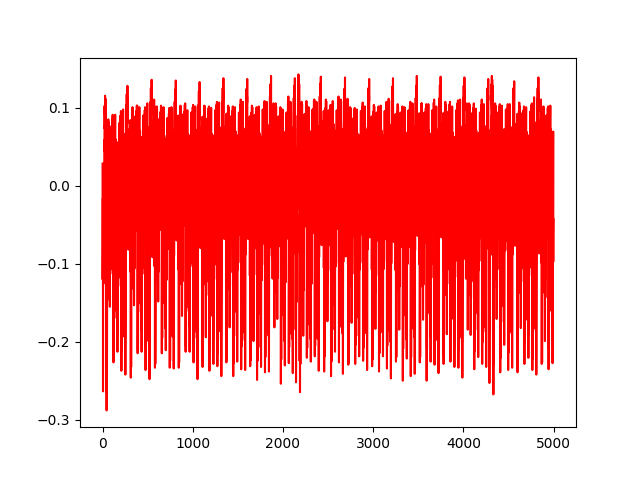

In [6]:
# plot the trace with matplotlib
%matplotlib notebook
import matplotlib.pylab as plt

plt.figure()
plt.plot(trace, 'r')
plt.show()

### ... with many traces

In [7]:
# trange shows a progress bar in for loop
from tqdm.notebook import trange
# numpy for speedy arrays
import numpy as np
import time

# this will be numpy arrays in the future,
# capturing traces and used nonce/counter elements
# this arrays will be used in the Attack-scenario Notebook
trace_array = []
nc_array = []

# define here the number of traces to be generated
# Attention!: High values require a large amount of memory to be allocated.
# Example: ntraces=20000 => min. 6GB RAM required; ntraces=10000 => min. 4GB RAM
####
ntraces = 5000
####

# ChipWhisperer allows to get fixed key elements and random nonce elements
ktp = cw.ktp.Basic()
# therefore get new "nc" (nonce/counter) (nonce (96 bit, 12 byte), counter (32 bit, 4 byte) => 128 bit = 16 Byte)
# the key is always the same => use nonce element
_, nc = ktp.next()

start_time = time.time()
for i in trange(ntraces, desc="Capturing "+str(ntraces)+" traces"):
    scope.arm()
    
    # send start trigger
    # write the generated nc element to target hardware
    target.simpleserial_write('p', nc, end='\n')

    ret = scope.capture()
    if ret:
            print('Timeout happened during acquisition')

    # get encrypted => will not be used
    encrypted = target.simpleserial_read('r', 64)
    
    # fill the trace and nonce/counter array with current values
    trace_array.append(scope.get_last_trace())
    nc_array.append(nc)
    
    # generate new nonce/counter
    _, nc = ktp.next()
    
# convert the arrays to better performance numpy arrays
trace_array = np.array(trace_array)
nc_array = np.array(nc_array)

print("--- %s ---" % (time.time() - start_time))

# additionally save the arrays as files
#np.save('trace_array50000-32byteinp.npy', trace_array)
#np.save('nc_array50000-32byteinp.npy', nc_array)

Capturing 50000 traces:   0%|          | 0/50000 [00:00<?, ?it/s]

--- 4943.013264417648 ---


In [ ]:
%matplotlib notebook
import matplotlib.pylab as plt

plt.figure()
plt.title(f"Captured traces: {ntraces}")
# plot each trace in array
for i in range(ntraces):
    plt.plot(trace_array[i])
plt.show()

<IPython.core.display.Javascript object>

### END: Disconnect hardware

In [1]:
try:
    scope.dis()
    target.dis()
except:
    pass

### Information

#### SCOPE information

In [3]:
try:
    print(cw.__version__)
    print(scope)
except:
    pass